## Feature Engineering

In [1]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf

### Train-Test Split

In [3]:
futures_df = pd.read_csv('./data/grains_and_cereals_futures.csv')
futures_df = futures_df[futures_df['commodity'] == 'KC HRW Wheat']
futures_df.drop(columns=['ticker', 'commodity'], inplace=True)

inflation_df = pd.read_csv('./data/us_inflation.csv')

weather_df = pd.read_parquet('./data/filtered_exporter_weather.parquet')

production_df = pd.read_csv('./data/global_wheat_dates.csv')

In [4]:
print('Futures:')
print(pd.to_datetime(futures_df['date']).describe())
print('Inflation:')
print(pd.to_datetime(inflation_df['date']).describe())
print('Weather:')
print(pd.to_datetime(weather_df['date']).describe())
print('Production:')
print(pd.to_datetime(production_df['date']).describe())

Futures:
count                             5976
mean     2012-08-06 04:40:43.373494016
min                2000-09-21 00:00:00
25%                2006-08-29 18:00:00
50%                2012-08-02 12:00:00
75%                2018-07-16 06:00:00
max                2024-06-24 00:00:00
Name: date, dtype: object
Inflation:
count                              308
mean     2012-10-15 20:15:35.064935168
min                2000-01-01 00:00:00
25%                2006-05-24 06:00:00
50%                2012-10-16 12:00:00
75%                2019-03-08 18:00:00
max                2025-08-01 00:00:00
Name: date, dtype: object
Weather:
count                       2381109
mean     2012-02-17 07:51:16.507458
min             2000-01-01 00:00:00
25%             2006-04-11 00:00:00
50%             2012-04-19 00:00:00
75%             2018-01-20 00:00:00
max             2023-09-05 00:00:00
Name: date, dtype: object
Production:
count                             3286
mean     2013-02-28 18:19:30.054777856
min  

In [5]:
# Because of the lack of weather data for 2023 and after, we will test on 2022 and train on all previous years
def train_segment(df):
    return df[df['date'] < '2022-01-01'].copy()

def test_segment(df):
    return df[(df['date'] >= '2022-01-01') & (df['date'] <= '2022-12-31')].copy()

futures_train_df = train_segment(futures_df)
futures_test_df = test_segment(futures_df)

inflation_train_df = train_segment(inflation_df)
inflation_test_df = test_segment(inflation_df)

production_train_df = train_segment(production_df)
production_test_df = test_segment(production_df)

weather_train_df = train_segment(weather_df)
weather_test_df = test_segment(weather_df)

### Futures

#### Classic Time Series

In [6]:
time_series_df = futures_train_df.copy()
time_series_df = time_series_df[['date', 'close']]
time_series_df['date'] = pd.Series(pd.to_datetime(arg=time_series_df['date'], format='%Y-%m-%d'))
time_series_df.sort_values('date', inplace=True)
time_series_df.set_index('date', inplace=True, drop=True)

In [7]:
px.line(
    time_series_df,
    x=time_series_df.index,
    y='close',
    title='Close Price in Time',
    labels={'date': 'Date', 'close': 'Close Price ($)'}
)

##### Trend

In [8]:
deterministic = DeterministicProcess(
    index=time_series_df.index,
    constant=True,
    order=1,
    drop=True
)

deterministic_df = deterministic.in_sample()
trend_df = pd.DataFrame({
    'constant': deterministic_df['const'],
    'trend': deterministic_df['trend'],
    'close': time_series_df['close']
})
trend_df

,constant,trend,close
date,,,
2000-09-21,1.0,1.0,293.75
2000-09-22,1.0,2.0,295.50
2000-09-25,1.0,3.0,299.50
2000-09-26,1.0,4.0,302.00
2000-09-27,1.0,5.0,307.75
...,...,...,...
2021-12-27,1.0,5351.0,847.00
2021-12-28,1.0,5352.0,821.75
2021-12-29,1.0,5353.0,824.50


In [9]:
linear_reg = LinearRegression(fit_intercept=False)
linear_reg.fit(X=trend_df.drop(columns='close'), y=trend_df['close'])

fitted_trend = linear_reg.predict(X=trend_df.drop(columns='close'))

fig = px.line(
    trend_df,
    x=trend_df.index,
    y='close',
    title='Linear Trend in the Training Data',
    labels={'date': 'Date', 'close': 'Close Price ($)'}
)
fig.add_trace(
    go.Scatter(
        x=trend_df.index,
        y=fitted_trend,
        line={'color': 'red', 'width': 2},
        name='Trend'
    )
)
fig.show()

##### Seasonality

In [10]:
dates = time_series_df.index
dates = pd.Series(pd.to_datetime(arg=dates, format='%Y-%m-%d'))
dates_df = pd.DataFrame({
        'date': dates,
        'day_of_week': dates.dt.day_of_week,
        'day_of_month': dates.dt.day,
        'day_of_year': dates.dt.day_of_year
})

weeks = dates_df['date'].dt.to_period('W').astype(int)
months = dates_df['date'].dt.to_period('M').astype(int)
years = dates_df['date'].dt.to_period('Y').astype(int)

dates_df['week_index'] = weeks - weeks.min() + 1
dates_df['month_index'] = months - months.min() + 1
dates_df['year_index'] = years - years.min() + 1

dates_df.set_index('date', drop=True, inplace=True)
dates_df['close'] = time_series_df['close']

dates_df

,day_of_week,day_of_month,day_of_year,week_index,month_index,year_index,close
date,,,,,,,
2000-09-21,3,21,265,1,1,1,293.75
2000-09-22,4,22,266,1,1,1,295.50
2000-09-25,0,25,269,2,1,1,299.50
2000-09-26,1,26,270,2,1,1,302.00
2000-09-27,2,27,271,2,1,1,307.75
...,...,...,...,...,...,...,...
2021-12-27,0,27,361,1111,256,22,847.00
2021-12-28,1,28,362,1111,256,22,821.75
2021-12-29,2,29,363,1111,256,22,824.50


In [11]:
fig = px.box(
    dates_df,
    x='day_of_week',
    y='close',
    title='Close Price Distributions by Day of Week',
    subtitle='Monday = 0, ... , Friday = 4'
)

fig.update_layout(
    xaxis_title='Day of Week',
    yaxis_title='Close Price ($)'
)

fig.show()

In [12]:
week_seasonality_df = dates_df.reset_index()[['date', 'week_index', 'day_of_week', 'close']].copy()

monday_prices = (
    week_seasonality_df[week_seasonality_df['day_of_week'] == 0]
    .set_index('week_index')['close']
)

week_seasonality_df['monday_price'] = week_seasonality_df['week_index'].map(monday_prices)
week_seasonality_df['close_rel'] = week_seasonality_df['close'] - week_seasonality_df['monday_price']

day_name_map = {i: name for i, name in enumerate(
    ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
)}
week_seasonality_df['day_name'] = week_seasonality_df['day_of_week'].map(day_name_map)

fig_week = px.line(
    week_seasonality_df,
    x='day_name',
    y='close_rel',
    color='week_index',
    line_group='week_index',
    markers=True,
    title='Close Price Seasonality (Week)',
    subtitle='Plotted prices are anchored in the Monday price of their respective week'
)

fig_week.update_layout(
    xaxis_title='Day of Week',
    yaxis_title='Close Price ($)',
    showlegend=False,
    xaxis={'categoryorder': 'array', 'categoryarray': ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']}
)

fig_week.show()

In [13]:
fig = px.box(
    dates_df,
    x='day_of_month',
    y='close',
    title='Close Price Distributions by Day of Month',
)

fig.update_layout(
    xaxis_title='Day of Month',
    yaxis_title='Close Price ($)'
)

fig.show()

In [14]:
month_seasonality_df = dates_df.reset_index()[['date', 'month_index', 'day_of_month', 'close']].copy()

month_anchor = month_seasonality_df.groupby('month_index').first()['close']

month_seasonality_df['month_anchor'] = month_seasonality_df['month_index'].map(month_anchor)
month_seasonality_df['close_rel'] = month_seasonality_df['close'] - month_seasonality_df['month_anchor']

fig_month = px.line(
    month_seasonality_df,
    x='day_of_month',
    y='close_rel',
    color='month_index',
    line_group='month_index',
    markers=True,
    title='Close Price Seasonality (Month)',
    subtitle='Plotted prices are anchored in the first day price of their respective month'
)

fig_month.update_layout(
    xaxis_title='Day of Month',
    yaxis_title='Close Price ($)',
    showlegend=False
)

fig_month.show()

In [15]:
year_quantiles_df = dates_df[['close', 'day_of_year']].groupby('day_of_year', observed=True).quantile(q=[0.05, 0.25, 0.5, 0.75, 0.95]) # type: ignore
year_stats_df = pd.DataFrame({
    'quant_05': year_quantiles_df.xs(0.05, level=1)['close'],
    'quant_25': year_quantiles_df.xs(0.25, level=1)['close'],
    'quant_50': year_quantiles_df.xs(0.5, level=1)['close'],
    'quant_75': year_quantiles_df.xs(0.75, level=1)['close'],
    'quant_95': year_quantiles_df.xs(0.95, level=1)['close']
})
year_stats_df.reset_index(inplace=True)

year_stats_melted = pd.melt(
    year_stats_df, 
    id_vars=['day_of_year'], 
    value_vars=['quant_05', 'quant_25', 'quant_50', 'quant_75', 'quant_95'],
    var_name='statistic', 
    value_name='close_price'
)

fig = px.scatter(
    year_stats_melted,
    x='day_of_year',
    y='close_price',
    color='statistic',
    title='Close Price Statistics by Day of Year',
    labels={'day_of_year': 'Day of Year', 'close_price': 'Close Price ($)', 'statistic': 'Statistic'}
)

fig.update_traces(mode='lines+markers')

fig.show()

In [16]:
year_seasonality_df = dates_df.reset_index()[['date', 'year_index', 'day_of_year', 'close']].copy()

year_anchor = year_seasonality_df.groupby('year_index').first()['close']

year_seasonality_df['year_anchor'] = year_seasonality_df['year_index'].map(year_anchor)
year_seasonality_df['close_rel'] = year_seasonality_df['close'] - year_seasonality_df['year_anchor']

fig_year = px.line(
    year_seasonality_df,
    x='day_of_year',
    y='close_rel',
    color='year_index',
    line_group='year_index',
    markers=True,
    title='Close Price Seasonality (Year)',
    subtitle='Plotted prices are anchored in the first day price of their respective year'
)

fig_year.update_layout(
    xaxis_title='Day of Year',
    yaxis_title='Close Price ($)',
    showlegend=False
)

fig_year.show()

In [17]:
fs = 252

frequencies, spectrum = periodogram(
    time_series_df['close'],
    fs=fs,
    detrend='linear',
    window='boxcar',
    scaling='spectrum',
)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=frequencies,
    y=spectrum,
    mode='lines',
    line={'width': 2},
    name='Spectrum'
))

fig.update_xaxes(type='log')

tick_values = [1, 2, 4, 6, 12, 21, 52, 126, 252]
tick_labels = [
    'Annual (1)',
    'Semi-annual (2)', 
    'Quarterly (4)',
    'Bi-monthly (6)',
    'Monthly (12)',
    'Trading Month (21)',
    'Weekly (52)',
    'Semi-weekly (126)',
    'Daily (252)'
]

fig.update_xaxes(
    tickvals=tick_values,
    ticktext=tick_labels,
    tickangle=30
)

fig.add_vline(x=1, line_dash='dash', line_color='red')

fig.update_layout(
    title='Close Price Periodogram',
    xaxis_title='Frequency (Cycles per Year)',
    yaxis_title='Variance',
)

fig.show()

In [18]:
fs = 252  # trading days per year

frequencies, spectrum = periodogram(
    time_series_df['close'],
    fs=fs,
    detrend='linear',
    window='boxcar',
    scaling='spectrum',
)

mask = frequencies >= 1
frequencies_filtered = frequencies[mask]
spectrum_filtered = spectrum[mask]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=frequencies_filtered,
    y=spectrum_filtered,
    mode='lines',
    line={'width': 2},
    name='Spectrum'
))

fig.update_xaxes(type='log')

tick_values = [1, 2, 4, 6, 12, 21, 52, 126, 252]
tick_labels = [
    'Annual (1)',
    'Semi-annual (2)', 
    'Quarterly (4)',
    'Bi-monthly (6)',
    'Monthly (12)',
    'Trading Month (21)',
    'Weekly (52)',
    'Semi-weekly (126)',
    'Daily (252)'
]

fig.update_xaxes(
    tickvals=tick_values,
    ticktext=tick_labels,
    tickangle=30
)

fig.update_layout(
    title='Close Price Periodogram (Frequencies ≥ 1)',
    xaxis_title='Frequency (Cycles per Year)',
    yaxis_title='Variance',
)

fig.show()

In [19]:
# top5 most significant frequencies >= 0.25 and >= 1
# excluding <= 0.25 because they seem to target the 2008 peak which looks like overfitting

frequencies_df = pd.DataFrame({
    'frequency': frequencies,
    'spectrum': spectrum
})

frequencies_df = frequencies_df[frequencies_df['frequency'] >= 0.25]
frequencies_df.sort_values('spectrum', ascending=False, inplace=True)
top_longer = frequencies_df.head(5)

frequencies_df = frequencies_df[frequencies_df['frequency'] >= 1]
frequencies_df.sort_values('spectrum', ascending=False, inplace=True)
top_shorter = frequencies_df.head(5)

print(top_longer)
print(top_shorter)

    frequency     spectrum
6    0.282353  1979.893506
8    0.376471  1576.796434
14   0.658824   683.256369
13   0.611765   485.195046
12   0.564706   446.245389
    frequency   spectrum
26   1.223529  93.675468
34   1.600000  80.243645
29   1.364706  66.956617
23   1.082353  64.222995
53   2.494118  61.239826


In [20]:
fourier_df = trend_df.copy()
frequencies = pd.concat([top_longer, top_shorter], axis=0, ignore_index=True)['frequency']

for freq in frequencies:
    fourier_df[f'sin({freq:.2f})'] = np.sin(2 * np.pi * freq * fourier_df['trend'])
    fourier_df[f'cos({freq:.2f})'] = np.cos(2 * np.pi * freq * fourier_df['trend'])

##### Auto-Correlation

In [21]:
auto_corr_df = time_series_df.copy()
for lag in range(1, 22):
    auto_corr_df[f'lag_{lag}'] = auto_corr_df['close'].shift(lag)

auto_corr_df.dropna(inplace=True)
auto_corr_df

,close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
date,,,,,,,,,,,,,,,,,,,,,
2000-10-20,309.00,308.75,312.75,319.50,324.00,320.00,326.75,326.50,325.50,318.50,...,318.00,320.50,321.00,320.00,310.75,307.75,302.00,299.50,295.50,293.75
2000-10-23,306.00,309.00,308.75,312.75,319.50,324.00,320.00,326.75,326.50,325.50,...,315.50,318.00,320.50,321.00,320.00,310.75,307.75,302.00,299.50,295.50
2000-10-24,305.50,306.00,309.00,308.75,312.75,319.50,324.00,320.00,326.75,326.50,...,318.50,315.50,318.00,320.50,321.00,320.00,310.75,307.75,302.00,299.50
2000-10-25,303.75,305.50,306.00,309.00,308.75,312.75,319.50,324.00,320.00,326.75,...,318.50,318.50,315.50,318.00,320.50,321.00,320.00,310.75,307.75,302.00
2000-10-26,305.00,303.75,305.50,306.00,309.00,308.75,312.75,319.50,324.00,320.00,...,325.50,318.50,318.50,315.50,318.00,320.50,321.00,320.00,310.75,307.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,847.00,861.50,853.75,841.50,813.25,810.00,803.75,785.50,805.25,808.50,...,810.25,827.25,821.50,822.00,838.50,814.25,819.00,854.00,865.00,873.25
2021-12-28,821.75,847.00,861.50,853.75,841.50,813.25,810.00,803.75,785.50,805.25,...,794.50,810.25,827.25,821.50,822.00,838.50,814.25,819.00,854.00,865.00
2021-12-29,824.50,821.75,847.00,861.50,853.75,841.50,813.25,810.00,803.75,785.50,...,801.50,794.50,810.25,827.25,821.50,822.00,838.50,814.25,819.00,854.00


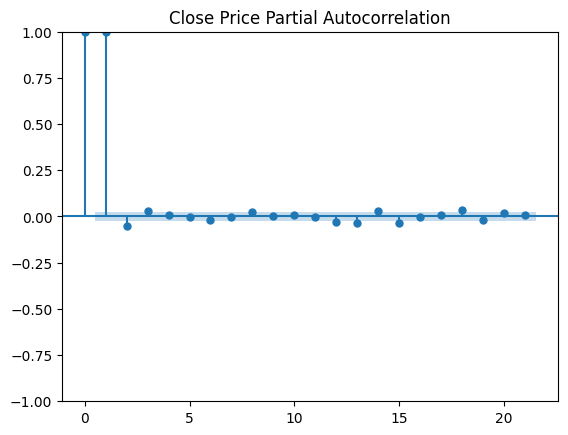

In [22]:
# Basically lag1 has all the information

fig = plot_pacf(
    x=auto_corr_df['close'],
    lags=21,
    alpha=0.05,
    title='Close Price Partial Autocorrelation'
)

#### Financial Technical Analysis

In [23]:
#### Relative Strength Index ####

# Smoothed Moving Average
# series[0] = NaN
def smma(series, window, series_length):
    arr = np.zeros(series_length)
    arr[0:window].fill(np.nan)
    
    arr[window] = np.mean(series[1:window+1])
    for i in range(window+1, series_length):
        arr[i] = (arr[i-1] * (window-1) + series[i]) / window
    
    return arr

def rsi(price_series, window):
    series_length = len(price_series)

    up = np.zeros(series_length)
    up[0] = np.nan
    for i in range(1,series_length):
        up[i] = max(price_series[i] - price_series[i-1], 0)

    down = np.zeros(series_length)
    down[0] = np.nan
    for i in range(1, series_length):
        down[i] = max(price_series[i-1] - price_series[i], 0)

    smma_up = smma(up, window, series_length)
    smma_down = smma(down, window, series_length)
    
    rsi = np.zeros(series_length)
    rsi[0:window].fill(np.nan)

    for i in range(window, series_length):
        if smma_up[i] == 0: rsi[i] = 0
        elif smma_down[i] == 0: rsi[i] = 100
        else:
            rsi[i] = 100 - (100 / (1 + (smma_up[i] / smma_down[i])))
    
    return rsi

In [24]:
#### Money Flow Index ####
MFI_WINDOW = 14

def mfi(high_series, low_series, close_series, volume_series):
    series_length = len(volume_series)
    typical_prices = (np.array(high_series) + np.array(low_series) + np.array(close_series)) / 3
    money_flows = np.array(typical_prices) * np.array(volume_series)
    
    positive_money_flows = np.zeros(series_length)
    positive_money_flows[0] = np.nan
    
    negative_money_flows = np.zeros(series_length)
    negative_money_flows[0] = np.nan
    
    for i in range(1, series_length):
        if typical_prices[i] > typical_prices[i-1]:
            positive_money_flows[i] = money_flows[i]
        else:
            negative_money_flows[i] = money_flows[i]

    mfi_series = np.zeros(series_length)
    mfi_series[:MFI_WINDOW-1].fill(np.nan)

    for i in range(MFI_WINDOW-1, series_length):
        positive_sum = np.sum(positive_money_flows[i-MFI_WINDOW+1:i+1])
        negative_sum = np.sum(negative_money_flows[i-MFI_WINDOW+1:i+1])
        
        if negative_sum == 0: mfi_series[i] = 100
        elif positive_sum == 0: mfi_series[i] = 0
        else:
            money_ratio = positive_sum / negative_sum
            mfi_series[i] = 100 - (100 / (1 + money_ratio))
    
    return mfi_series

In [25]:
#### Volatility ####
VOLATILITY_PERIODS_PER_YEAR = 252  # Trading days per year

def volatility(price_series, window):
    series_length = len(price_series)

    ln_returns = np.log(pd.Series(price_series) / pd.Series(price_series).shift(1))
    
    volatility_arr = np.zeros(series_length)
    volatility_arr[:window].fill(np.nan)
    
    for i in range(window, series_length):
        volatility_arr[i] = np.std(ln_returns[i-window+1:i+1], ddof=1) * np.sqrt(VOLATILITY_PERIODS_PER_YEAR)
    
    return volatility_arr

In [26]:
fintech_df = futures_train_df.copy()
fintech_df.sort_values('date', inplace=True)
fintech_df.reset_index(drop=True, inplace=True)

In [27]:
# Gaps seen during exploration

fintech_df[(fintech_df['date'] >= '2009-01-01') & (fintech_df['date'] <= '2011-01-01')].describe()

,open,high,low,close,volume
count,504.000000,504.000000,504.000000,504.000000,504.0
mean,584.891865,594.191468,577.479663,585.156250,0.0
std,100.140556,102.414270,98.492949,100.425634,0.0
min,457.750000,460.500000,453.500000,456.500000,0.0
25%,501.000000,507.937500,495.187500,501.000000,0.0
50%,558.000000,563.625000,549.125000,557.125000,0.0
75%,641.875000,655.500000,638.312500,644.937500,0.0
max,861.250000,863.500000,842.500000,860.500000,0.0


In [28]:
# Fill the volume with the mean where 0 (it's missing data)
# No data leakage, because it's expanding mean

fintech_df['volume'] = fintech_df['volume'].mask(
    fintech_df['volume'] == 0, 
    fintech_df['volume'].where(fintech_df['volume'] != 0).expanding().mean()
)
fintech_df[(fintech_df['date'] >= '2009-01-01') & (fintech_df['date'] <= '2011-01-01')].describe()


,open,high,low,close,volume
count,504.000000,504.000000,504.000000,504.000000,504.00000
mean,584.891865,594.191468,577.479663,585.156250,2899.37035
std,100.140556,102.414270,98.492949,100.425634,0.00000
min,457.750000,460.500000,453.500000,456.500000,2899.37035
25%,501.000000,507.937500,495.187500,501.000000,2899.37035
50%,558.000000,563.625000,549.125000,557.125000,2899.37035
75%,641.875000,655.500000,638.312500,644.937500,2899.37035
max,861.250000,863.500000,842.500000,860.500000,2899.37035


In [29]:
fintech_df['sma_5'] = fintech_df['close'].rolling(window=5, min_periods=5, center=False, closed='both').mean()
fintech_df['sma_21'] = fintech_df['close'].rolling(window=21, min_periods=21, center=False, closed='both').mean()

fintech_df['ema_5'] = fintech_df['close'].ewm(span=5, adjust=False, min_periods=5).mean()
fintech_df['ema_21'] = fintech_df['close'].ewm(span=21, adjust=False, min_periods=21).mean()

fintech_df['rsi_5'] = rsi(fintech_df['close'], 5)
fintech_df['rsi_21'] = rsi(fintech_df['close'], 21)

fintech_df['mfi'] = mfi(fintech_df['high'], fintech_df['low'], fintech_df['close'], fintech_df['volume'])

fintech_df['volatility_5'] = volatility(fintech_df['close'], 5)
fintech_df['volatility_21'] = volatility(fintech_df['close'], 21)


In [30]:
# Financial indicators must be shifted, because they include the present day close price.
# All rows with NaN values must be dropped as they do not contain full information.

corrected_fintech_df = fintech_df.copy()

fintech_columns = [
    'sma_5', 'sma_21', 'ema_5', 'ema_21',
    'rsi_5', 'rsi_21', 'mfi',
    'volatility_5', 'volatility_21' 
]

for column in fintech_columns:
    corrected_fintech_df[column] = corrected_fintech_df[column].shift(1)

corrected_fintech_df.drop(columns=['date', 'open', 'high', 'low', 'volume'], inplace=True)
corrected_fintech_df.dropna(inplace=True)


In [31]:
correlation_matrix = corrected_fintech_df.corr()

heatmap = px.imshow(
    correlation_matrix,
    text_auto='.2f', # type: ignore
    title='Financial Indicators and Close Price Correlations',
    color_continuous_scale='RdYlGn',
    labels={'color': 'Correlation'}
)

correlation_matrix.sort_values('close', ascending=True, inplace=True)

bar_plot = px.bar(
    x=correlation_matrix['close'][:-1],
    y=correlation_matrix.index[:-1],
    title='Correlation between Financial Indicators and Close Price',
    labels={'x': 'Correlation', 'y': ''}
)

heatmap.show()
bar_plot.show()

In [32]:
# The orders of magnitude, means, and std are not the same. Normalization is needed.

corrected_fintech_df.describe()

,close,sma_5,sma_21,ema_5,ema_21,rsi_5,rsi_21,mfi,volatility_5,volatility_21
count,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000
mean,536.988234,536.656455,535.901853,536.704565,535.939789,49.757541,50.402821,49.555502,0.259678,0.276601
std,180.464492,180.042392,178.885560,179.967024,178.329790,20.238332,9.592200,19.213188,0.126449,0.086890
min,271.250000,274.000000,276.852273,274.776340,278.256995,1.397189,26.384017,0.000000,0.000000,0.068530
25%,405.250000,406.458333,405.193182,405.872547,405.944123,34.061159,43.605399,36.125132,0.170052,0.213547
50%,490.500000,490.250000,489.420455,490.377722,490.453226,48.716482,49.599507,49.692074,0.238626,0.267174
75%,658.000000,656.791667,658.636364,658.022458,658.894116,65.082550,56.656252,63.353722,0.323498,0.328593
max,1337.000000,1248.333333,1187.715909,1256.706090,1185.216843,99.161759,87.038329,100.000000,1.141897,0.793102


In [33]:
scaled_fintech_df = corrected_fintech_df.copy()

feature_columns = [col for col in corrected_fintech_df.columns if col != 'close']

scaler = StandardScaler()
scaled_fintech_df[feature_columns] = scaler.fit_transform(corrected_fintech_df[feature_columns])

mutual_info = mutual_info_regression(
    X=scaled_fintech_df.drop(columns='close'),
    y=scaled_fintech_df['close'],
    discrete_features=False
)
mutual_info_df = pd.DataFrame(mutual_info)
mutual_info_df.index = scaled_fintech_df.drop(columns='close').columns
mutual_info_df.columns = ['mutual_info']
mutual_info_df.sort_values('mutual_info', ascending=True, inplace=True)

In [34]:
px.bar(
    x=mutual_info_df['mutual_info'],
    y=mutual_info_df.index,
    title='Mutual Information between Financial Indicators and Close Price',
    labels={'x': 'Mutual Information', 'y': ''}
)

### Weather

In [35]:
# Recall TOP5 exporters
# 0     United States of America
# 2                       Russia
# 3                       Canada
# 4                    Australia
# 5                      Ukraine

<img src="https://ipad.fas.usda.gov/countrysummary/images/US/cropprod/USA_Wheat.png" width="600" height="400">
<img src="https://ipad.fas.usda.gov/countrysummary/images/RS/cropprod/Russia_total_wheat.jpg" width="600" height="400">
<img src="https://ipad.fas.usda.gov/countrysummary/images/CA/cropprod/Canada_Wheat.png" width="600" height="400">
<img src="https://ipad.fas.usda.gov/countrysummary/images/AS/cropprod/Australia_wheat.jpg" width="600" height="400">
<img src="https://ipad.fas.usda.gov/countrysummary/images/UP/cropprod/Ukraine_wheat.jpg" width="600" height="400">


In [36]:
# Cities with weather stations approx corresponding to the regions on maps

us_region1 = ['Oklahoma City', 'Topeka', 'Lincoln']
us_region2 = ['Bismarck', 'Helena']
us_region3 = ['Olympia']

can_region1 = ['Toronto']
can_region2 = ['Edmonton', 'Regina']
can_region3 = ['Whitehorse']

rus_region1 = ['Makhachkala', 'Nalchik', 'Cherkessk', 'Stavropol', 'Maykop', 'Krasnodar', 'Elista']
rus_region2 = ['Rostov-on-Don', 'Volgograd', 'Kursk', 'Voronezh']
rus_region3 = ['Kazan', 'Ulyanovsk', 'Samara']

aus_region1 = ['Perth']
aus_region2 = ['Adelaide']
aus_region3 = ['Melbourne', 'Canberra']

ukr_region1 = ['Ternopil', 'Khmelnytskyi', 'Vinnytsia']
ukr_region2 = ['Odessa', 'Kropyvnytskyi', 'Poltava']
ukr_region3 = ['Kherson', 'Dnipro', 'Kharkiv', 'Donetsk']

producer_cities = us_region1 + us_region2 + us_region3 \
                + can_region1 + can_region2 + can_region3 \
                + rus_region1 + rus_region2 + rus_region3 \
                + aus_region1 + aus_region2 + aus_region3 \
                + ukr_region1 + ukr_region1 + ukr_region3

In [37]:
# For weather choose only snow, precipitation, temp. Fill snow with 0s and wind, temp with avgs
weather_features_df = weather_train_df.copy()

In [38]:
weather_features_df = weather_features_df[weather_features_df['city_name'].isin(producer_cities)]
weather_features_df = weather_features_df[['station_id', 'city_name', 'date', 'avg_temp_c',
                                           'min_temp_c', 'max_temp_c', 'precipitation_mm', 'snow_depth_mm']]

In [39]:
weather_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 237631 entries, 3299 to 27546
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   station_id        237631 non-null  category      
 1   city_name         237631 non-null  category      
 2   date              237631 non-null  datetime64[us]
 3   avg_temp_c        213502 non-null  float64       
 4   min_temp_c        220309 non-null  float64       
 5   max_temp_c        222125 non-null  float64       
 6   precipitation_mm  175139 non-null  float64       
 7   snow_depth_mm     74777 non-null   float64       
dtypes: category(2), datetime64[us](1), float64(5)
memory usage: 13.7 MB


In [40]:
from itertools import product

date_range = pd.date_range(
    start=weather_features_df['date'].min(), 
    end=weather_features_df['date'].max(), 
    freq='D'
)
station_ids = weather_features_df['station_id'].unique()

complete_combinations = list(product(station_ids, date_range))
complete_index_df = pd.DataFrame(complete_combinations, columns=['station_id', 'date'])

weather_complete_df = complete_index_df.merge(
    weather_features_df, 
    on=['station_id', 'date'], 
    how='left'
)

city_region_map = weather_features_df[['station_id', 'city_name']].drop_duplicates()
weather_complete_df['city_name'] = weather_complete_df['city_name'].fillna(
    weather_complete_df['station_id'].map(city_region_map.set_index('station_id')['city_name'])
)

In [41]:
# Filling with all time average and not expanding might be controversial,
# but assuming they come from the same distribution, it doesn't matter.
# Also it's not data leakage, because nothing is revealed from the test set.

weather_complete_df = weather_complete_df.sort_values(['station_id', 'date'])

fill_mean_columns = ['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm']

for col in fill_mean_columns:
    weather_complete_df[col] = weather_complete_df.groupby('station_id', observed=True)[col].transform(
        lambda x: x.fillna(x.mean())
    )

weather_complete_df['snow_depth_mm'] = weather_complete_df['snow_depth_mm'].fillna(0)

weather_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265188 entries, 80360 to 24107
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   station_id        265188 non-null  object        
 1   date              265188 non-null  datetime64[ns]
 2   city_name         265188 non-null  category      
 3   avg_temp_c        265188 non-null  float64       
 4   min_temp_c        265188 non-null  float64       
 5   max_temp_c        265188 non-null  float64       
 6   precipitation_mm  265188 non-null  float64       
 7   snow_depth_mm     265188 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(5), object(1)
memory usage: 16.7+ MB


In [42]:
city_to_region = {}

for city in us_region1:
    city_to_region[city] = 'us1'
for city in us_region2:
    city_to_region[city] = 'us2'
for city in us_region3:
    city_to_region[city] = 'us3'

for city in can_region1:
    city_to_region[city] = 'can1'
for city in can_region2:
    city_to_region[city] = 'can2'
for city in can_region3:
    city_to_region[city] = 'can3'

for city in rus_region1:
    city_to_region[city] = 'rus1'
for city in rus_region2:
    city_to_region[city] = 'rus2'
for city in rus_region3:
    city_to_region[city] = 'rus3'

for city in aus_region1:
    city_to_region[city] = 'aus1'
for city in aus_region2:
    city_to_region[city] = 'aus2'
for city in aus_region3:
    city_to_region[city] = 'aus3'

for city in ukr_region1:
    city_to_region[city] = 'ukr1'
for city in ukr_region2:
    city_to_region[city] = 'ukr2'
for city in ukr_region3:
    city_to_region[city] = 'ukr3'

In [43]:
weather_complete_df['region'] = weather_complete_df['city_name'].map(city_to_region)

weather_regional_df = weather_complete_df.groupby(['region', 'date']).agg({
    'avg_temp_c': 'mean',
    'min_temp_c': 'min',
    'max_temp_c': 'max',
    'precipitation_mm': 'mean',
    'snow_depth_mm': 'mean'
}).reset_index()

weather_regional_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112504 entries, 0 to 112503
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   region            112504 non-null  object        
 1   date              112504 non-null  datetime64[ns]
 2   avg_temp_c        112504 non-null  float64       
 3   min_temp_c        112504 non-null  float64       
 4   max_temp_c        112504 non-null  float64       
 5   precipitation_mm  112504 non-null  float64       
 6   snow_depth_mm     112504 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 6.0+ MB


In [44]:
weather_pivot_df = weather_regional_df.pivot(index='date', columns='region')

weather_pivot_df.columns = [f"{region}_{measurement}" for measurement, region in weather_pivot_df.columns]

weather_pivot_df = weather_pivot_df.reset_index()

In [45]:
weather_close_df = futures_train_df.copy()[['date', 'close']]
weather_close_df['date'] = pd.to_datetime(weather_close_df['date'])

weather_for_merge_df = weather_pivot_df.copy()
weather_for_merge_df['date'] = pd.to_datetime(weather_for_merge_df['date'])

weather_close_df = weather_close_df.merge(
    weather_for_merge_df,
    on='date',
    how='inner'
)
weather_close_df.describe()

,date,close,aus1_avg_temp_c,aus2_avg_temp_c,aus3_avg_temp_c,can1_avg_temp_c,can2_avg_temp_c,can3_avg_temp_c,rus1_avg_temp_c,rus2_avg_temp_c,...,can2_snow_depth_mm,can3_snow_depth_mm,rus1_snow_depth_mm,rus2_snow_depth_mm,rus3_snow_depth_mm,ukr1_snow_depth_mm,ukr3_snow_depth_mm,us1_snow_depth_mm,us2_snow_depth_mm,us3_snow_depth_mm
count,5355,5355.000000,5355.000000,5355.000000,5355.000000,5355.000000,5355.000000,5355.000000,5355.000000,5355.000000,...,5355.000000,5355.000000,5355.000000,5355.000000,5355.000000,5355.000000,5355.000000,5355.000000,5355.000000,5355.000000
mean,2011-05-13 10:42:09.075630336,536.073249,18.463566,11.333936,13.688278,10.132429,3.829694,0.326510,10.567412,8.435807,...,26.714846,47.936508,5.969499,29.278182,53.443448,19.167196,11.530812,4.955805,20.926891,0.151821
min,2000-09-21 00:00:00,271.250000,10.100000,3.400000,4.450000,-19.100000,-34.200000,-43.100000,-14.073233,-25.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2006-01-18 12:00:00,403.625000,18.471350,11.329282,11.071271,2.900000,-5.075000,-7.250000,4.016667,1.433333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2011-05-11 00:00:00,490.000000,18.471350,11.329282,13.571271,9.953341,4.900000,1.200000,10.626767,8.587466,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2016-09-04 00:00:00,656.000000,18.471350,11.329282,16.071271,18.700000,14.700000,10.100000,17.360100,16.093733,...,22.500000,20.000000,0.000000,13.666667,0.000000,0.000000,0.000000,0.000000,12.500000,0.000000
max,2021-12-31 00:00:00,1337.000000,33.800000,25.300000,29.100000,31.600000,27.250000,25.600000,30.066667,30.033333,...,310.000000,490.000000,227.833333,420.000000,706.666667,1013.666667,499.750000,226.666667,355.000000,330.000000
std,NaN,180.657046,1.017366,0.988800,3.153715,9.839200,12.224885,11.887567,7.934173,9.334399,...,53.914492,96.686897,22.418037,65.046710,124.738665,53.631742,32.742996,19.961500,50.752502,6.109228


In [46]:
scaled_weather_df = weather_close_df.copy()

feature_columns = [col for col in scaled_weather_df.columns if col != 'close' and col != 'date']

scaler = StandardScaler()
scaled_weather_df[feature_columns] = scaler.fit_transform(scaled_weather_df[feature_columns])

mi_weather = mutual_info_regression(
    X=scaled_weather_df.drop(columns=['close', 'date']),
    y=scaled_weather_df['close'],
    discrete_features=False
)

weather_labels = scaled_weather_df.drop(columns=['close', 'date']).columns

mi_weather_df = pd.DataFrame({
    'measurement': weather_labels,
    'mutual_info': mi_weather
})

mi_weather_df = mi_weather_df[mi_weather_df['mutual_info'] >= 0.01]
mi_weather_df.sort_values('mutual_info', ascending=True, inplace=True)
mi_weather_df.reset_index(inplace=True, drop=True)

In [47]:
px.bar(
    mi_weather_df,
    x='mutual_info',
    y='measurement',
    title='Mutual Information between Weather Measurements and Close Price',
    labels={'measurement': '', 'mutual_info': 'Mutual Information'}
)

### Production and Trade

In [48]:
# Recall TOP5 exporters
# 0     United States of America
# 2                       Russia
# 3                       Canada
# 4                    Australia
# 5                      Ukraine

In [49]:
exporters = ['United States', 'Russia', 'Canada', 'Australia', 'Ukraine']

filtered_production_df = production_train_df.copy()[production_train_df['country'].isin(exporters)]
filtered_production_df.drop(columns='commodity', inplace=True)
filtered_production_df['date'] = pd.to_datetime(filtered_production_df['date'], format='%Y-%m-%d')
filtered_production_df['year'] = filtered_production_df['date'].dt.year + 1

In [50]:
filtered_production_df.head()

,date,country,beginning_stocks,production,imports,exports,domestic_consumption,ending_stocks,yield,year
6,1999-12-31,Australia,2838,24757,61,17844,5227,4585,2.04,2000
19,1999-12-31,Canada,7425,26941,190,19165,8092,7299,2.60,2000
87,1999-12-31,Russia,1062,30995,5083,518,35365,1257,1.56,2000
108,1999-12-31,Ukraine,1900,13585,453,1952,12186,1800,2.29,2000
110,1999-12-31,United States,25744,62475,2572,29570,35373,25848,2.87,2000


In [51]:
production_close_df = futures_train_df.copy()[['date', 'close']]
production_close_df['date'] = pd.to_datetime(production_close_df['date'], format='%Y-%m-%d')
production_close_df['year'] = production_close_df['date'].dt.year

In [52]:
country_codes = {
    'United States': 'us',
    'Russia': 'rus',
    'Canada': 'can',
    'Australia': 'aus',
    'Ukraine': 'ukr',
}

metrics = [col for col in filtered_production_df.columns if col not in ['country', 'date', 'year']]

production_wide_df = (
    filtered_production_df.assign(country_code=lambda df: df['country'].map(country_codes))
    .pivot_table(index='year', columns='country_code', values=metrics, aggfunc='first')
)

production_wide_df.columns = [
    f"{country}_{metric}" for metric, country in production_wide_df.columns
]
production_wide_df = production_wide_df.reset_index()

futures_with_production_df = (
    futures_train_df.assign(year=pd.to_datetime(futures_train_df['date']).dt.year)
    .merge(production_wide_df, on='year', how='left')
    .drop(columns='year')
)

futures_with_production_df.drop(columns=['open', 'date', 'high', 'low', 'volume'], inplace=True)

futures_with_production_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5355 entries, 0 to 5354
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   close                     5355 non-null   float64
 1   aus_beginning_stocks      5355 non-null   int64  
 2   can_beginning_stocks      5355 non-null   int64  
 3   rus_beginning_stocks      5355 non-null   int64  
 4   ukr_beginning_stocks      5355 non-null   int64  
 5   us_beginning_stocks       5355 non-null   int64  
 6   aus_domestic_consumption  5355 non-null   int64  
 7   can_domestic_consumption  5355 non-null   int64  
 8   rus_domestic_consumption  5355 non-null   int64  
 9   ukr_domestic_consumption  5355 non-null   int64  
 10  us_domestic_consumption   5355 non-null   int64  
 11  aus_ending_stocks         5355 non-null   int64  
 12  can_ending_stocks         5355 non-null   int64  
 13  rus_ending_stocks         5355 non-null   int64  
 14  ukr_endi

In [53]:
feature_columns = [col for col in futures_with_production_df.columns if col != 'close']

scaler = StandardScaler()
futures_with_production_df[feature_columns] = scaler.fit_transform(futures_with_production_df[feature_columns])

mi_production = mutual_info_regression(
    X=futures_with_production_df.drop(columns='close'),
    y=futures_with_production_df['close'],
    discrete_features=False
)

production_labels = futures_with_production_df.drop(columns='close').columns

mi_production_df = pd.DataFrame({
    'metric': production_labels,
    'mutual_info': mi_production
})

mi_production_df.sort_values('mutual_info', ascending=True, inplace=True)

px.bar(
    y=mi_production_df['metric'],
    x=mi_production_df['mutual_info'],
    labels={'x': 'Mutual Information', 'y': ''},
    title='Mutual Information between Production/Trade Metrics and Close Price'
)

### Inflation

In [54]:
inflation_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 264 entries, 0 to 263
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           264 non-null    object 
 1   mom_inflation  264 non-null    float64
 2   yoy_inflation  264 non-null    float64
dtypes: float64(2), object(1)
memory usage: 8.2+ KB


In [55]:
inflation_monthly_df = (
    inflation_train_df.assign(
        date=pd.to_datetime(inflation_train_df['date']),
        month_key=lambda df: df['date'].dt.to_period('M')
    )
    [['month_key', 'mom_inflation', 'yoy_inflation']]
)

futures_with_inflation_df = (
    futures_train_df.assign(
        date=pd.to_datetime(futures_train_df['date']),
        month_key=lambda df: df['date'].dt.to_period('M')
    )
    .merge(inflation_monthly_df, on='month_key', how='left')
    .drop(columns='month_key')
)

In [56]:
futures_with_inflation_df.drop(columns=['date', 'open', 'high', 'low', 'volume'], inplace=True)

In [57]:
scaler = StandardScaler()
futures_with_inflation_df[['mom_inflation', 'yoy_inflation']] = scaler.fit_transform(futures_with_inflation_df[['mom_inflation', 'yoy_inflation']])

mi_inflation = mutual_info_regression(
    X=futures_with_inflation_df.drop(columns='close'),
    y=futures_with_inflation_df['close'],
    discrete_features=False
)

inflation_labels = futures_with_inflation_df.drop(columns='close').columns

mi_inflation_df = pd.DataFrame({
    'metric': inflation_labels,
    'mutual_info': mi_inflation
})

mi_inflation_df.sort_values('mutual_info', ascending=True, inplace=True)

px.bar(
    y=mi_inflation_df['metric'],
    x=mi_inflation_df['mutual_info'],
    labels={'x': 'Mutual Information', 'y': ''},
    title='Mutual Information between Inflation Metrics and Close Price'
)
